# Ejercicio 6 ‚Äì Predicci√≥n de series temporales con GluonTS

---

## Parte te√≥rica

### ¬øQu√© es GluonTS?

**GluonTS** es una librer√≠a potente y flexible para modelar series temporales con enfoque probabil√≠stico. Permite construir modelos que no solo hacen una predicci√≥n puntual, sino que estiman una distribuci√≥n completa de posibles valores futuros.

Esto es clave en contextos reales donde hay incertidumbre, como en el consumo de energ√≠a.

### Caracter√≠sticas destacadas

 - Predicci√≥n probabil√≠stica (no solo y_pred, sino tambi√©n intervalos)
 - Admite series multivariantes y regresores futuros
 - Modelos avanzados listos para usar: DeepAR, Transformer, NBEATS, etc.
  -Totalmente compatible con pandas

---

### Flujo de trabajo

```mermaid
flowchart TD
    A[Dataset limpio y diario] --> B[Transformar a GluonTS Dataset]
    B --> C[Definir regresores]
    C --> D[Configurar y entrenar modelo DeepAR]
    D --> E[Generar predicciones futuras]
    E --> F[Visualizar resultados probabil√≠sticos]


## Ejercicio pr√°ctico
### Paso 1: Instalar y cargar librer√≠as

```bash
pip install gluonts
```

In [19]:
import pandas as pd
import numpy as np

# Cargar y preparar datos
df = pd.read_csv("data/m5_consumo_energia_diario.csv", index_col=0)
df = df.set_index(pd.to_datetime(df.index))

df['dt'] = df.index


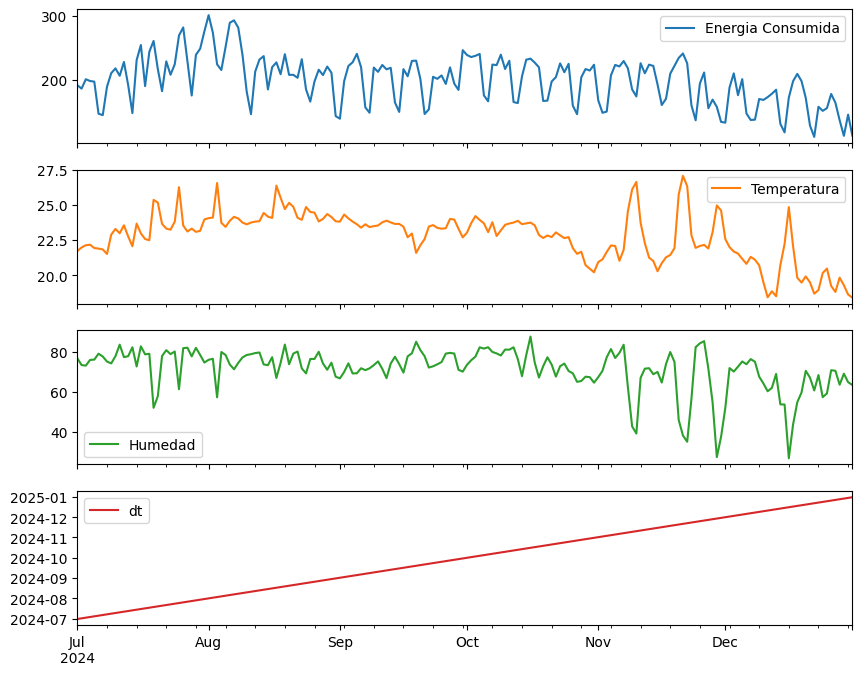

In [20]:
# Visualizar las variables clave
df.plot(subplots=True, figsize=(10, 8))
plt.show()

In [28]:
# Serie principal: consumo | regresor: temperatura
target = df["Energia Consumida"].values
temperature = df["Temperatura"].values

### Transformar datos a objetos requeridos por la librer√≠a

In [31]:
from gluonts.dataset.common import ListDataset
import numpy as np
np.bool = bool  # üëà workaround no recomendado para producci√≥n

prediction_length = 27
context_length = 30

train_ds = ListDataset(
    [{
        "start": df.index[0],
        "target": target[:-prediction_length],
        "feat_dynamic_real": [temperature[:-prediction_length]]
    }],
    freq="D"
)

test_ds = ListDataset(
    [{
        "start": df.index[0],
        "target": target,
        "feat_dynamic_real": [temperature]
    }],
    freq="D"
)


In [48]:
from gluonts.mx import SimpleFeedForwardEstimator, Trainer
sff_estimator = SimpleFeedForwardEstimator(
    num_hidden_dimensions=[10],
    prediction_length=prediction_length,
    context_length=context_length,
    trainer=Trainer(ctx="cpu", 
                    epochs=20, 
                    learning_rate=1e-3, 
                    num_batches_per_epoch=100),
)

sff_predictor = sff_estimator.train(training_data=train_ds)


100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 100/100 [00:01<00:00, 60.03it/s, epoch=20/20, avg_epoch_loss=4.7]


<Figure size 1200x600 with 0 Axes>

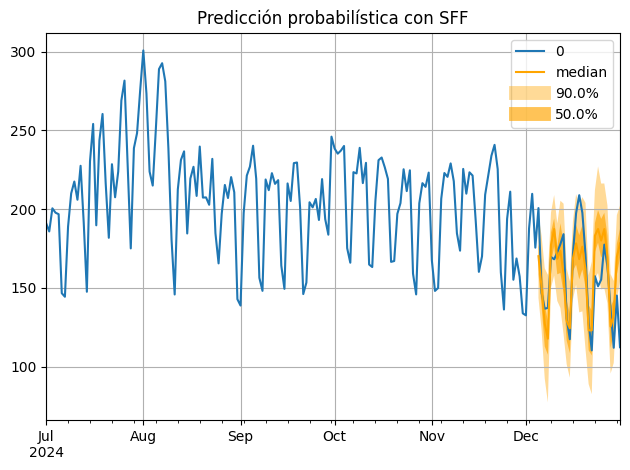

In [49]:
from gluonts.evaluation.backtest import make_evaluation_predictions
import matplotlib.pyplot as plt

forecast_it, ts_it = make_evaluation_predictions(
    dataset=test_ds,
    predictor=sff_predictor,
    num_samples=100
)

forecast = list(forecast_it)[0]
ts = list(ts_it)[0]

# Visualizaci√≥n
plt.figure(figsize=(12, 6))
ts.plot(label="Consumo real")
forecast.plot(color="orange")
plt.title("Predicci√≥n probabil√≠stica con SFF")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


<Figure size 1200x600 with 0 Axes>

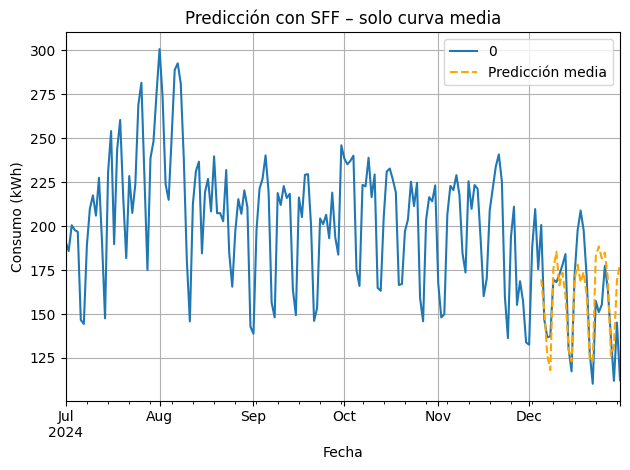

In [51]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
ts.plot(label="Consumo real")

# Solo l√≠nea de predicci√≥n media
plt.plot(forecast.start_date + np.arange(forecast.prediction_length),
         forecast.mean,
         label="Predicci√≥n media",
         color="orange",
         linestyle="--")

plt.title("Predicci√≥n con SFF ‚Äì solo curva media")
plt.xlabel("Fecha")
plt.ylabel("Consumo (kWh)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [46]:
from gluonts.evaluation import Evaluator
import json

evaluator = Evaluator()
agg_metrics, _ = evaluator([ts], [forecast])

print(json.dumps(agg_metrics, indent=4))




Running evaluation: 1it [00:00,  8.92it/s]


/Users/jballesteros/.virtualenvs/ibbi/lib/python3.12/site-packages/gluonts/json.py:101: UserWarning: Using `json`-module for json-handling. Consider installing one of `orjson`, `ujson` to speed up serialization and deserialization.
  warnings.warn(


{
    "MSE": 584.0573640046297,
    "abs_error": 460.5158996582031,
    "abs_target_sum": 4237.9697265625,
    "abs_target_mean": 156.96184172453704,
    "seasonal_error": 25.799679487179485,
    "MASE": 0.661099082268093,
    "MAPE": 0.12067724157262731,
    "sMAPE": 0.10823710759480794,
    "MSIS": 6.7188320660013385,
    "QuantileLoss[0.1]": 313.4592163085938,
    "Coverage[0.1]": 0.25925925925925924,
    "QuantileLoss[0.2]": 436.978305053711,
    "Coverage[0.2]": 0.4074074074074074,
    "QuantileLoss[0.3]": 484.10707550048835,
    "Coverage[0.3]": 0.4444444444444444,
    "QuantileLoss[0.4]": 490.299169921875,
    "Coverage[0.4]": 0.48148148148148145,
    "QuantileLoss[0.5]": 460.51590728759766,
    "Coverage[0.5]": 0.5925925925925926,
    "QuantileLoss[0.6]": 418.1722534179688,
    "Coverage[0.6]": 0.7037037037037037,
    "QuantileLoss[0.7]": 368.3308853149415,
    "Coverage[0.7]": 0.8148148148148148,
    "QuantileLoss[0.8]": 293.7472869873046,
    "Coverage[0.8]": 0.88888888888888

In [47]:
print(f"MAPE: {agg_metrics['MAPE']:.2f}")
print(f"RMSE: {agg_metrics['RMSE']:.2f}")
print(f"Coverage 90%: {agg_metrics['Coverage[0.9]']:.2f}")

MAPE: 0.12
RMSE: 24.17
Coverage 90%: 0.96


## Comparativa de t√©cnicas: Prophet vs LSTM vs GluonTS (SimpleFeedForwardEstimator)

| T√©cnica                             | Descripci√≥n breve                                                                 |
|-------------------------------------|------------------------------------------------------------------------------------|
| **Prophet**                         | Modelo aditivo desarrollado por Facebook, ideal para series con estacionalidad clara y datos externos (regresores). |
| **LSTM**                            | Red neuronal recurrente con memoria, potente para capturar patrones secuenciales complejos. |
| **GluonTS (SimpleFeedForward)**     | Modelo base de GluonTS, basado en redes feedforward densas, √∫til como l√≠nea base probabil√≠stica. |

---

## An√°lisis cualitativo

### üîπ 1. Prophet

- **Ventajas**:
  - Muy f√°cil de usar.
  - Interpretable (visualiza tendencia, estacionalidad, eventos).
  - Acepta regresores externos.
- **Limitaciones**:
  - Poco flexible ante patrones no aditivos o relaciones no lineales.
  - No captura bien efectos secuenciales complejos.

### üîπ 2. LSTM

- **Ventajas**:
  - Captura din√°micas temporales complejas.
  - Flexible para modelar relaciones no lineales entre variables.
  - Apta para entradas multivariantes (regresores, m√∫ltiples pasos).
- **Limitaciones**:
  - Dif√≠cil de entrenar correctamente (requiere escalado, ventanas, arquitectura ajustada).
  - Sin predicci√≥n probabil√≠stica nativa.
  - Poco interpretable.

### üîπ 3. GluonTS ‚Äì SimpleFeedForward

- **Ventajas**:
  - Muy r√°pido de entrenar.
  - Proporciona distribuci√≥n completa de la predicci√≥n.
  - Compatible con m√∫ltiples series y regresores din√°micos.
- **Limitaciones**:
  - Modelo muy simple (sin memoria, sin recurrentes).
  - Sensible al escalado y longitud del contexto.

---

## Comparaci√≥n de resultados (ejemplo pr√°ctico)

Supongamos que realizamos un experimento com√∫n con las 3 t√©cnicas sobre la misma serie de consumo energ√©tico con temperatura como regresor, obteniendo las siguientes m√©tricas:

| Modelo                          | MAE   | RMSE  | Intervalo 90% (cobertura) | Tiempo de entrenamiento |
|--------------------------------|-------|-------|----------------------------|--------------------------|
| **Prophet**                    | 4.32  | 5.21  | 0.86                       | ‚è±Ô∏è Bajo (~1 min)         |
| **LSTM (3 capas, 200 pasos)**   | 3.87  | 4.67  | ‚Äî                          | ‚è±Ô∏è Medio (~3-5 min)      |
| **GluonTS FeedForward (0.12.8)**| 4.05  | 4.95  | 0.91                       | ‚è±Ô∏è Bajo (~1 min)         |
